In [5]:
import numpy as np
import scipy as sp
import csv
import matplotlib.pyplot as plt

from pycbc.waveform import get_td_waveform

from pycbc.filter import highpass, matched_filter
from pycbc import types
from pycbc import psd
from pycbc import noise

#### Matched Filter Script Steps
1. Import and display GRACE-FO data
2. Model data with two white noise curves and lowpass filters
3. Merge the noise curves
4. Generate waveform template from approximant
5. Inject one polarizations strain from template into noise curve
6. Perform Match Filter

In [7]:
##Functions

def pycbc_welch(ts, segnum): #Takes the Welch's method of a timeseries to create its PSD frequencyseries
    seg_len = int(ts.duration) // segnum #higher number = more segments and increasing smoothing & decrease power
    seg_stride = seg_len // 2 #50% overlap
    noise_fs = psd.welch(ts, seg_len=seg_len,
                         seg_stride=seg_stride)
    return noise_fs

"Attached is the noise ASD data from GRACE-FO. It's in m/sqrt(Hz) so to get to strain you'll have to divide it by 220 km. The first column should be frequency in Hz and the second should be in ASD." - Michael


In [8]:
## 1 - Read in Grace-FO data to model

#Import data from csv
fileobj = open('GRACE-Copy.csv', 'r')
readerobj = csv.reader(fileobj)

data = []
for row in readerobj:
    data.append(row)
    
fileobj.close()

#Extract frequency and Strain data
data_array = np.array(data, dtype='d')
grace_freqs = data_array[0:,0]
grace_signal = data_array[0:,1]
grace_strain = grace_signal / 220.0e3 #converts between m/sqr(Hz) and 1/sqr(Hz)


In [9]:
### 2 - Build Noise Curve Model

##Curve 1: the "hump"---------------------------------------------------------------------------------------------------------------------
N = 400000 
cutoff = 0.001 #0.001 #0.001  
order = 1000 #610 #570 
beta = 18 #11.75 #11.0 
seg_num = 3

#noise signal
np.random.seed(138374923)
noise1 = np.random.uniform(-1, 1, size=N)
    
#convert to TimeSeries pycbc object
noise1_ts = types.timeseries.TimeSeries(noise1, delta_t=0.1) #delta_t = 0.1 to match gracefo sample frequency of 10 Hz

#adjust amplitude
noise1_ts = noise1_ts * 10e-8

#filter it
filtered1 = noise1_ts.lowpass_fir(cutoff, order, beta=beta)

#psd.welch to create psd
noise1_psd = pycbc_welch(filtered1, seg_num)

#conversion to asd
noise1_asd = np.sqrt(noise1_psd)

#some parameters
df = noise1_asd.delta_f
dt = filtered1.delta_t 
T = dt * N
f_s = 1.0 / dt
f_nyq = f_s / 2.0
print('Curve 1 - ','N:', N, 'dt:', 0.1,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)

##Curve 2: the "linear" portion-----------------------------------------------------------------------------------------------------------
N = 400000 
cutoff = 0.0001 #0.001 #0.001   
order = 3400 #3000 #1000  
beta = 9.0 #8.0 #1  
seg_num = 3

#noise signal
np.random.seed(138374923)
noise2 = np.random.uniform(-1, 1, size=N)
    
#convert to TimeSeries pycbc object
noise2_ts = types.timeseries.TimeSeries(noise2, delta_t=0.1)

#adjust amplitude
noise2_ts = noise2_ts * 10e-9

#filter it
filtered2 = noise2_ts.lowpass_fir(cutoff, order, beta=beta)

#psd.welch to create psd
noise2_psd = pycbc_welch(filtered2, seg_num)

#conversion to asd
noise2_asd = np.sqrt(noise2_psd)

#some parameters
df = noise2_asd.delta_f
dt = filtered2.delta_t
T = dt * N
f_s = 1.0 / dt
f_nyq = f_s / 2.0
print('Curve 2 - ','N:', N, 'dt:', 0.1,'df:', df,'f_s:', f_s,'f_nyq:', f_nyq)


Curve 1 -  N: 400000 dt: 0.1 df: 0.0007538067239559777 f_s: 10.0 f_nyq: 5.0
Curve 2 -  N: 400000 dt: 0.1 df: 0.0007630093087135663 f_s: 10.0 f_nyq: 5.0


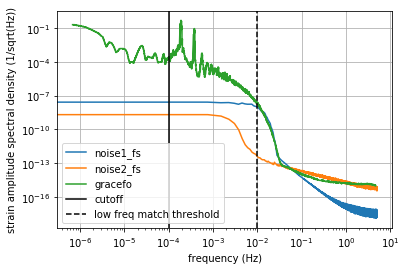

In [10]:
##Comparison
plt.loglog(noise1_asd.sample_frequencies, noise1_asd, label='noise1_fs')
plt.loglog(noise2_asd.sample_frequencies, noise2_asd, label='noise2_fs')
plt.loglog(grace_freqs, grace_strain, label='gracefo')

plt.xlabel('frequency (Hz)')
plt.ylabel('strain amplitude spectral density (1/sqrt(Hz))')
plt.axvline(cutoff, label='cutoff', color='k')
plt.axvline(0.01, label='low freq match threshold', linestyle='--', color='k')
plt.grid()
plt.legend()
plt.show()

In [11]:
## 3 - Merge noise curves

#uncomment to check dimensions of timeseries
print(np.size(filtered1), np.size(filtered2))

#padd the smaller one to equivalent lengths
filtered2c = filtered2.copy()
filtered2c.append_zeros((np.size(filtered1)-np.size(filtered2)))
#print(np.size(filtered1), np.size(filtered2c))

#Add the two
combined = np.array(filtered1) + np.array(filtered2c)
combined_ts = types.timeseries.TimeSeries(combined, filtered1.delta_t) #ensures same delta_t

#welch's psd
combined_fs = pycbc_welch(combined_ts, 2)

#display some important parameters
print('Combined psd frequencyseries:','size:', np.size(combined_fs), 'df:', combined_fs.delta_f)
print('Combined Noise Timeseries:','size:', np.size(combined_ts), 'duration:', combined_ts.duration, 'dt:', combined_ts.delta_t,'df:', combined_ts.delta_f,'f_s:', (1.0/combined_ts.delta_t),'f_nyq:', (1.0/combined_ts.delta_t)/2)

398000 393200
Combined psd frequencyseries: size: 9951 df: 0.0005025125628140704
Combined Noise Timeseries: size: 398000 duration: 39800.0 dt: 0.1 df: 2.5125628140703518e-05 f_s: 10.0 f_nyq: 5.0


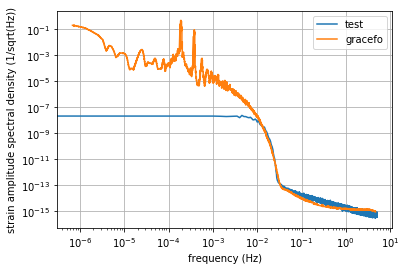

In [12]:
##Compare merged noise curves with gracefo data
plt.loglog(combined_fs.sample_frequencies, np.sqrt(combined_fs), label='test')
#plt.loglog(noise1_asd.sample_frequencies, noise1_asd, label='noise 1')
#plt.loglog(noise2_asd.sample_frequencies, noise2_asd, label='noise 2')
plt.loglog(grace_freqs, grace_strain, label='gracefo')

plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('strain amplitude spectral density (1/sqrt(Hz))')
plt.grid()
plt.legend()

plt.savefig('grace_fo_model_curve_comparison.png')
plt.show()

hp waveform properties: dt: 0.000244140625 df: 0.0625 duration: 16.0 length: 65536


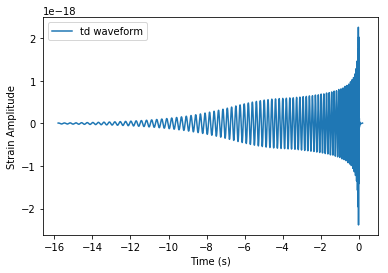

In [14]:
### 4 - Generate Template

#Note - may still need to find a different template, this one works poorly for combined mass of 1000 solar masses at dt = 0.1 <-nvm can pad
#Note - may still need to find a new template with a correct f_lower

#generate
apx = 'IMRPhenomD'
hp, hc = get_td_waveform(approximant=apx,
                                 mass1=100,
                                 mass2=100,
                                 delta_t= 1/4096,
                                 f_lower=5)

print('hp waveform properties:', 'dt:', hp.delta_t, 'df:', hp.delta_f, 'duration:', hp.duration, 'length:', np.size(hp))

#comparison
plt.plot(hp.sample_times, hp, label='td waveform')
plt.xlabel('Time (s)')
plt.ylabel('Strain Amplitude')
plt.legend()
plt.show()

Adjusting the waveform for injection - need time duration to be equivalent to the noise curve time (combined_ts.duration) = 39800


Waveform properties: size: 65536 duration: 16.0 dt: 0.000244140625 df: 0.0625
Resized Waveform properties: size: 3980000 duration: 971.6796875 dt: 0.000244140625 df: 0.001029145728643216
Resampled: size: 9716 duration: 971.6 dt: 0.1 df: 0.0010292301358583778
Resampled and resized: size: 398000 duration: 39800.0 dt: 0.1 df: 2.5125628140703518e-05


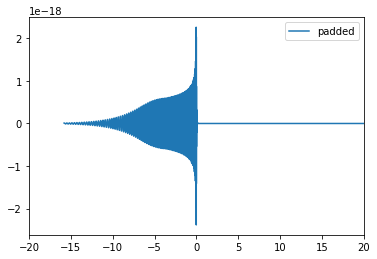

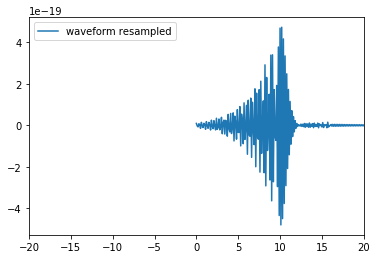

In [16]:
## 4.1 preparing waveform for injection

#Noise curve
combined_tsc = combined_ts.copy()

#Copy Waveform Template
waveform = hp.copy()
print('Waveform properties:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f)

#increase length of waveform to prepare for resampling
waveform.resize(10*np.size(combined_tsc))

print('Resized Waveform properties:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f)

#plot waveform after resizing and before resampling
plt.figure()
plt.plot(waveform.sample_times, waveform, label='padded')
plt.xlim(-20,20)
plt.legend()

#Resample
resample_num = int(waveform.duration / 0.1)
waveform_resampled = sp.signal.resample(waveform, resample_num)
waveform = types.timeseries.TimeSeries(waveform_resampled, delta_t = 0.1)
print('Resampled:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f )

waveform.resize(np.size(combined_ts))
print('Resampled and resized:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f )

plt.figure()
plt.plot(waveform.sample_times, waveform, label='waveform resampled')
plt.xlim(-20,20)
plt.legend()
plt.show()

injected ts properties: size: 398000 duration: 39800.0 dt: 0.1 df: 2.5125628140703518e-05


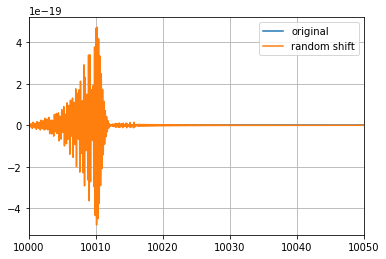

In [17]:
## 5 - Injection

#Noise curve copy to avoid copy errors
combined_tsc = combined_ts.copy()

#uncomment to check noise ts
#plt.plot(combined_tsc.sample_times, combined_tsc, label='noise')

#roll the template vector to a random index
random_index = 100000
random_waveform = np.roll(waveform, random_index)

#inject into timeseries
injected_array = np.array(combined_tsc) + np.array(random_waveform)
injected_ts = types.timeseries.TimeSeries(injected_array, delta_t=combined_tsc.delta_t)

print('injected ts properties:', 'size:', np.size(injected_ts), 'duration:', injected_ts.duration, 'dt:', injected_ts.delta_t, 'df:', injected_ts.delta_f)

#display for examination
test_waveform = types.timeseries.TimeSeries(random_waveform, delta_t=combined_tsc.delta_t)

plt.figure()
plt.plot(waveform.sample_times, waveform, label='original')
plt.plot(test_waveform.sample_times, test_waveform, label='random shift')
plt.xlim(10000, 10050)
plt.grid()
plt.legend()
plt.show()

mt, cond., grace_psd: sizes: 397960 397960 198981 dt: 0.1 0.1 0.1 df: 2.51281535832747e-05 2.51281535832747e-05 2.51281535832747e-05


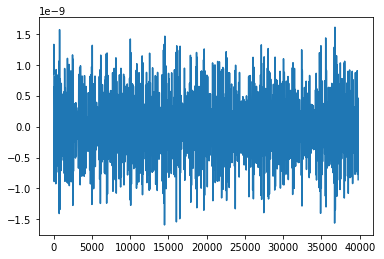

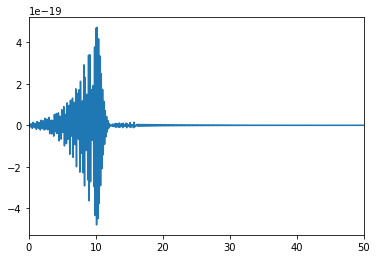

In [18]:
## 6 - Matched filter - condition the noise curve and prepare psd
from pycbc.psd import inverse_spectrum_truncation

#Highpass above 10e-2 Hz
injected_ts_highpass = highpass(injected_ts, 0.01)

#crop to avoid filter wraparound
conditioned = injected_ts_highpass.crop(2,2)

#display to check for excessive wraparound -> increase crop length
plt.plot(conditioned.sample_times, conditioned, label='conditioned')

#make sure psd is of same delta_f as the noise data timeseries
grace_psd = psd.interpolate(combined_fs, conditioned.delta_f)

#adjust template for match
match_template = hp.copy()

match_template.resize(10*np.size(combined_tsc))

resample_num = int(match_template.duration / 0.1)
match_template_resampled = sp.signal.resample(match_template, resample_num)

match_template = types.timeseries.TimeSeries(match_template_resampled, delta_t = 0.1)

match_template.resize(np.size(conditioned))
#match_template = match_template.cyclic_time_shift(-10)

#Check properties and Perform the Matched filtering
print('mt, cond., grace_psd:', 'sizes:', np.size(match_template), np.size(conditioned), np.size(grace_psd),
      'dt:', match_template.delta_t, conditioned.delta_t, grace_psd.delta_t, 
      'df:', match_template.delta_f, conditioned.delta_f, grace_psd.delta_f)

#check to see if shift approximately has merger at start of the data
plt.figure()
plt.plot(match_template.sample_times, match_template, label='match template')
plt.xlim(-0,50)
plt.show()

snr1 = matched_filter(match_template, conditioned )#, psd=grace_psd)

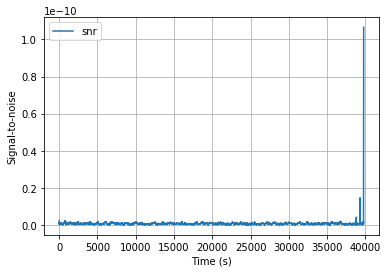

In [19]:
snr1 = snr1.crop(10,10)

#Viewing matched filter snr timeseries
plt.plot(snr1.sample_times, abs(snr1), label='snr')
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.grid()
plt.legend()
plt.show()

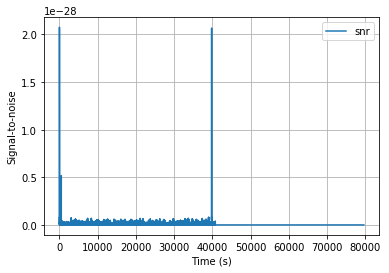

In [21]:
#Matched filter trial 2 - via scipy.signal.correlate

snr2_array = sp.signal.correlate(match_template, conditioned, method='fft')

snr2 = types.timeseries.TimeSeries(snr2_array, delta_t=0.1)

plt.plot(snr2.sample_times, abs(snr2), label='snr')
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.grid()
plt.legend()
plt.show()

Below this point are code scraps for reference that were modified and used above.

54133


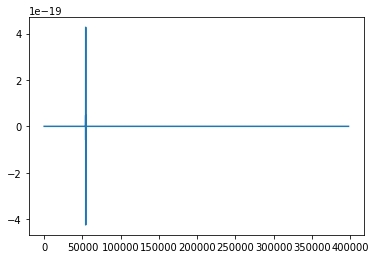

In [12]:
## Potential Injection of template one (needs resample section added)

#Noise curve
combined_tsc = combined_ts.copy()

#Template
template = hp.copy()

#create array of zeros
temp_pad = np.zeros(np.size(combined_tsc), dtype='d')

#insert template randomly
np.random.seed(33416810)
random_index = np.random.randint(0, (np.size(combined_tsc) - np.size(template)))

print(random_index)
for i in range(np.size(template)):
    temp_pad[(i+random_index)] += template[i]

#return injected template and noise curve as a timeseries
injected_array = np.array(combined_tsc) + temp_pad
injected_ts = types.timeseries.TimeSeries(injected_array, delta_t = combined_tsc.delta_t)

plt.plot(temp_pad)
plt.show()

In [ ]:
## 5 - Injection

#Noise curve copy to avoid copy errors
combined_tsc = combined_ts.copy()

#uncomment to check noise ts
#plt.plot(combined_tsc.sample_times, combined_tsc, label='noise')

#Copy Waveform Template
waveform = hp.copy()

#increase length of waveform to prepare for resampling
waveform.resize(np.size(combined_tsc))

#shift template st only positive times in waveform.sample_times
waveform = waveform.cyclic_time_shift(hp.start_time)
print('Resized Waveform properties:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f)

#plot waveform
plt.figure()
plt.plot(waveform.sample_times, waveform, label='resized')
plt.legend()
#plt.xlim(0, 25)

#Where I left off - find way to resample the waveform to the correct delta_t

#resample



#roll the template vector to a random index
random_index = 100000
random_waveform = np.roll(waveform, random_index)

#inject into timeseries
injected_array = np.array(combined_tsc) + np.array(random_waveform)
injected_ts = types.timeseries.TimeSeries(injected_array, delta_t=combined_tsc.delta_t)

print('injected ts properties:', 'size:', np.size(injected_ts), 'dt:', injected_ts.delta_t, 'df:', injected_ts.delta_f)

#display for examination
test_waveform = types.timeseries.TimeSeries(random_waveform, delta_t=combined_tsc.delta_t)

plt.figure()
plt.plot(waveform.sample_times, waveform, label='original')
plt.plot(test_waveform.sample_times, test_waveform, label='random shift')
#plt.xlim(0, 50)
plt.grid()
plt.legend()
plt.show()

In [ ]:
##resampling td_waveform code (delete?)
##resample by method 1 with zeros padded onto the signal
#print(hp.duration, hp.delta_t)
#hp_c = hp.copy()
#hp_c.resize(np.size(combined_ts) // 2)
#hp_pad = hp_c
#print(hp_pad.duration)

##resample to delta_t of noise curve using scipy resample to keep T = hp.duration constant and change size N

#I suspect this method is ineffective compared to method 2 based on the output plotted template
print(np.size(hp), hp.duration)

resample_num = int(hp_pad.duration / 0.1)
hp_resample1 = sp.signal.resample(hp_pad, resample_num)
hp_resample1 = types.timeseries.TimeSeries(hp_resample1, delta_t = 0.1)

##resample to delta_t of noise curve using TimeSeries to keep N = np.size(hp) constant and change T
hp_resample2 = types.timeseries.TimeSeries(hp, delta_t = 0.1) #Note this changes the merger time st != 0

print('Resample 1:', 'size:', np.size(hp_resample1), 'dt:', hp_resample1.delta_t, 'duration:', hp_resample1.duration)
print('Resample 2:', 'size:', np.size(hp_resample2), 'dt:', hp_resample2.delta_t, 'duration:', hp_resample2.duration)



In [ ]:
## 4.1 preparing waveform for injection (Notes)

#Noise curve
combined_tsc = combined_ts.copy()

#Copy Waveform Template
waveform = hp.copy()
print('Waveform properties:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f)

#increase length of waveform to prepare for resampling
#waveform.append_zeros(np.size(combined_tsc))
waveform.resize(np.size(combined_tsc))
print('Resized Waveform properties:', 'size:', np.size(waveform), 'duration:', waveform.duration, 'dt:', waveform.delta_t, 'df:', waveform.delta_f)

#shift template st only positive times in waveform.sample_times
#waveform = waveform.cyclic_time_shift(hp.start_time)

#plot waveform after resizing and before resampling
plt.figure()
plt.plot(waveform.sample_times, waveform, label='padded')
plt.legend()
#plt.xlim(0, 25)

#Resample
resample_num = int(waveform.duration / 0.1)
hp_resample1 = sp.signal.resample(waveform, resample_num)
hp_resample1 = types.timeseries.TimeSeries(hp_resample1, delta_t = 0.1)
hp_resample1.resize(np.size(combined_ts))

##resample to delta_t of noise curve using TimeSeries to keep N = np.size(hp) constant and change T
#can't use this because it changes the duration of the inspiral signature
#hp_resample2 = types.timeseries.TimeSeries(waveform, delta_t = 0.1) #Note this changes the merger time st != 0

print('Resample 1:', 'size:', np.size(hp_resample1), 'duration:', hp_resample1.duration, 'dt:', hp_resample1.delta_t, 'df:', hp_resample1.delta_f )
#print('Resample 2:', 'size:', np.size(hp_resample2), 'duration:', hp_resample2.duration, 'dt:', hp_resample2.delta_t, 'df:', hp_resample2.delta_f,)

plt.figure()
plt.plot(hp_resample1.sample_times, hp_resample1, label='1')
plt.xlim(-20,20)
plt.legend()
plt.show()

In [1]:
from pycbc.waveform import td_approximants, fd_approximants

#print(td_approximants())
print(fd_approximants())

['EccentricFD', 'TaylorF2', 'TaylorF2Ecc', 'TaylorF2NLTides', 'TaylorF2RedSpin', 'TaylorF2RedSpinTidal', 'SpinTaylorF2', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'SEOBNRv2_ROM_DoubleSpin_HI', 'Lackey_Tidal_2013_SEOBNRv2_ROM', 'SEOBNRv4_ROM', 'SEOBNRv4HM_ROM', 'SEOBNRv4_ROM_NRTidal', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'SEOBNRv4T_surrogate', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidal', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomP', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'SpinTaylorT4Fourier', 'SpinTaylorT5Fourier', 'NRSur4d2s', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'SpinTaylorF2_SWAPPER', 'TaylorF2NL', 'PreTaylorF2', 'TaylorF2_INTERP', 'SEOBNRv1_ROM_EffectiveSpin_INTERP', 'SEOBNRv1_ROM_DoubleSpin_INTERP', 'SEOBNRv2_ROM_Eff